# Problema 1

Paralelo : 200

Profesor: Esteban Daines

Integrantes:

1.Anastasiia Fedorova, ROL:201873505-1

2.Tomás Fernández Allamand, ROL:201873542-6


## Modules import

In [1]:
import cv2
import math
import numpy as np
from scipy.spatial import distance as dist
import imutils
import matplotlib.pyplot as plt
import Utilities as ut

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


## Shape and type detection auxilary functions

In [2]:
def parallel(vertexList,margin):
    paral = 0
    vertex1=vertexList[0][0][0],vertexList[0][0][1] #tuples (coordinate1,coordinate2)
    vertex2=vertexList[1][0][0],vertexList[1][0][1]
    vertex3=vertexList[2][0][0],vertexList[2][0][1]
    vertex4=vertexList[3][0][0],vertexList[3][0][1]
    slope1 = abs(ut.slope(vertex1,vertex2))
    slope2 = abs(ut.slope(vertex2,vertex3))
    slope3 = abs(ut.slope(vertex3,vertex4))
    slope4 = abs(ut.slope(vertex4,vertex1))
    if ut.equal(slope1,slope2,margin):
        paral +=1
    if ut.equal(slope2,slope3,margin): #all comparison combinations
        paral +=1
    if ut.equal(slope3,slope4,margin):
        paral +=1
    if ut.equal(slope4,slope1,margin):
        paral +=1
    return paral


def equalAngles(vertexList,margin):
    eq = 0
    alpha = ut.internalAngle(vertexList,0)
    beta = ut.internalAngle(vertexList,1)  #function is only called while analyzing a quad
    gamma = ut.internalAngle(vertexList,2)
    omega = ut.internalAngle(vertexList,3)
    if ut.equal(alpha, beta, margin):
        eq += 1
    if ut.equal(beta, gamma, margin):
        eq += 1
    if ut.equal(gamma, omega, margin):
        eq += 1
    if ut.equal(alpha, omega, margin):
        eq += 1
    if ut.equal(alpha, gamma, margin): #all posible combinations: 4!/(2!2!)=6
        eq +=1
    if ut.equal(beta, omega, margin):
        eq += 1
    return eq

def equalSides(vertexList,margin,type):
    eq = 0
    if type == 'triangulo':                             #only called while analyzing a triangle
        vertex1=vertexList[0][0][0],vertexList[0][0][1] #tuples (coordinate1,coordinate2)
        vertex2=vertexList[1][0][0],vertexList[1][0][1]
        vertex3=vertexList[2][0][0],vertexList[2][0][1]
        side1 = ut.distance(vertex1,vertex2)
        side2 = ut.distance(vertex2,vertex3)
        side3 = ut.distance(vertex1,vertex3)
        if ut.equal(side1, side2, margin):
            eq += 1
        if ut.equal(side2, side3, margin):
            eq += 1
        if ut.equal(side1, side3, margin):
            eq += 1
    if type == 'cuadrilatero':                          #only called while analyzing a quad
        vertex1=vertexList[0][0][0],vertexList[0][0][1] #tuples (coordinate1,coordinate2)
        vertex2=vertexList[1][0][0],vertexList[1][0][1]
        vertex3=vertexList[2][0][0],vertexList[2][0][1]
        vertex4=vertexList[3][0][0],vertexList[3][0][1]
        side1=ut.distance(vertex1,vertex2)
        side2=ut.distance(vertex2,vertex3)
        side3=ut.distance(vertex3,vertex4)
        side4=ut.distance(vertex1,vertex4)
        if ut.equal(side1, side2, margin):
            eq += 1
        if ut.equal(side2, side3, margin):
            eq += 1
        if ut.equal(side3, side4, margin):
            eq += 1
        if ut.equal(side1, side4, margin):
            eq += 1
    return eq



## Shape and type detection main functions

In [3]:
#the dictionary used to get a shape's name by the number of its sides, more shapes can be added if necessary.
dictShapes = {3:'triangulo',4:'cuadrilatero',5:'pentagono',6:'hexagono',7:'heptagono',\
8:'octogono',9:'eneagono',10:'decagono',11:'endecagono',12:'dodecagono'}

def detectShape(cntr,margin): #input: contour,error margin, output: shape,triangle type, quad type
    shape = 'no shape'
    triangle = "no triangulo"
    quad = "no cuadrilatero"
    if len(cntr) in dictShapes: 
        shape = dictShapes[len(cntr)]
        if shape == 'triangulo':
            triangle = triangle_type(cntr,margin)
        elif shape == 'cuadrilatero':
            quad = quadrilateral_type(cntr,margin)
    else:
        if len(cntr) > 12:
            shape = 'circulo'
        #in any other case returns default 'no shape','no triangulo','no cuadrilatero'
    return shape,triangle,quad

#auxilary triangle type detection function
def triangle_type(cntr,margin): #input: contour,error margin, output: triangle type
    equality = equalSides(cntr,margin,'triangulo')
    if equality == 3: #3 equal pairs
        return "equilatero"
    elif equality == 0 : # none are equal
        return "escaleno"
    else: 
        return "isosceles"

#auxilary triangle type detection function
def quadrilateral_type(cntr, margin): #input: contour,error margin, output: quad type
    if not ut.isConvex(cntr): 
        return 'otro'
    elif ut.isConvex(cntr):
        if equalAngles(cntr,margin) == 6: #6 combinations in total, 4!/(2!2!)
            if equalSides(cntr,margin,'cuadrilatero') == 4: 
                return 'cuadrado'
            else:
                return 'rectangulo'
        elif equalAngles(cntr,margin) == 2:
                if equalSides(cntr,margin,'cuadrilatero') == 4:
                    return 'rombo' 
                else:
                    if equalSides(cntr,margin,'cuadrilatero') == 2:
                        return 'romboide' #does consider, in this the case, that rhomboid == parallelogram 
        else:
            if parallel(cntr,margin) == 1:
                return 'trapecio' #a pair of parallel sides

    else:
        return 'trapezoide'

## RGB dictionary and RGB2LAB transformation

In [4]:
colorDictionary = {
    "blanco": (255,255,255),  #white RGB
    "rojo": (255, 0, 0), #red RGB
    "verde": (0, 255, 0), #green RGB
    "azul": (0, 0, 255), #blue RGB
    "amarillo": (255,255,0), #yellow RGB
    "cyan": (0,255,255), #cyan RGB
    "fucsia": (255,0,255), #fucsia RGB
}


# Create an array (matrix) to save colors and transform them to LAB format later.
labColors = np.zeros((len(colorDictionary), 1, 3), dtype="uint8")
# Create a list to save corresponding color names.
labColorNames = []


# Iterate over color dictionary and save values in respective lists.
for (i, (name, rgb)) in enumerate(colorDictionary.items()):
    labColors[i] = rgb
    labColorNames.append(name)

'''
enumerate(colorDictionary.items()) has this form:
(0, ('blanco', (255, 255, 255)))
(1, ('rojo', (255, 0, 0)))
(2, ('fucsia', (244, 0, 161)))
(3, ('amarillo', (255, 255, 0)))...
'''

# Convert array to LAB color format
labColors = cv2.cvtColor(labColors, cv2.COLOR_RGB2LAB)
# Input: Image image; Contour c.

'''3D array looks like this
[[[255 128 128]]
 [[136 208 195]]
 [[137 213 111]]...]'''

#Note: the array has the same order of colors as the list labColorNames.Order is 'randomized' every time the program is executed.



'3D array looks like this\n[[[255 128 128]]\n [[136 208 195]]\n [[137 213 111]]...]'

## Color detection (same color and opposite color)

In [5]:
def EuclidianDistance(t1,t2): #t1 - tuple with FP (mean), t2- list of integers (color of the figure)
    dist = ((t1[0]-float(t2[0]))**2 + (t1[1]-float(t2[1]))**2 + (t1[2]-float(t2[2]))**2)**0.5
    return dist

def detectColor(image, c):
    # Create contour mask to ignore rest of the image.
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)

    # Obtain mean value of contour internal color.
    mean = cv2.mean(image, mask=mask)[:3]
    # Loop over array to find the closest in range.
    closestColor = ''
    minDistance = float('inf')
    count = 0 #represets an index in labColorNames
    for l in labColors:
        if EuclidianDistance(mean,l[0]) < minDistance:
            #Searchest for the smallest distance.
            closestColor = labColorNames[count]
            minDistance = EuclidianDistance(mean,l[0])
        count += 1
    return closestColor
    #labColors - array of colors in LAB mode
    #labColorNames - list of colors in the same order as presented in the array




#DETECT OPPOSITE COLOR
# Input: Image image; Contour c.
# Output: Name of color from color dictionary with maximal distance to contour's color.
#         Values -> "rojo","verde","azul","amarillo","fucsia","cyan","blanco"
def detectOppositeColor(image, c):
    # Create contour mask to ignore rest of the image.
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)

    # Obtain mean value of contour internal color.
    mean = cv2.mean(image, mask=mask)[:3]
    oppositeColor = ''
    maxDistance = -float('inf') # for searching for the biggest tuple
    count = 0 #represets an index in labColorNames
    for l in labColors:
        if EuclidianDistance(mean,l[0]) > maxDistance:
            #searches for the greatest distance
            oppositeColor = labColorNames[count]
            maxDistance = EuclidianDistance(mean,l[0])
        count += 1
    return oppositeColor
#alternatively, could have used enumerate to get index of every color, used count instead.


## Define file name and load the file

In [6]:
fileNames = ["formas","formas2","triangulos","triangulos2","cuadrilateros"]
imageName = fileNames[0] #range (0,4) in this case, used for selection of the file.
# OpenCV loads image in BRG format
image = cv2.imread(imageName +'.png')

# caso 'formas2' - el 'romboide' no es el rombo segun calculos / al verficar en editor de imagines
# caso 'formas2' - triangulos blanco y rojo estan anotados en orden inverso 
# hay error de anotacion de color en txt - magenta en vez de celeste en uno de los casos 

## Manipulating the image

In [7]:
# OpenCv uses BRG format, convert it to RGB
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize image
resizeRatio = 2 #the bigger the number, the slower but more exact is the shape detection.
resized = imutils.resize(image, width=int(resizeRatio*image.shape[1]))

# Blur image slightly
blurred = cv2.GaussianBlur(resized, (5, 5), 0)

# Convert blurred image grayscale and the L*a*b* color spaces
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)

# Use a threshold to create a two colored image 
minimumThreshold = 10
# threshold value, if pixels value is lower / higher than it it is assigned one value (may be white), 
#else it is assigned another value (may be black)
thresh = cv2.threshold(gray, minimumThreshold, 255, cv2.THRESH_BINARY)[1]

## Encontrar Contornos

In [8]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

## Inicializar Listas

In [9]:
results = list()
shapes = list()
colors = list()
triangles = list()
quads = list()

## Iterar en Contornos, Detectar Forma y Color.

In [10]:
# Loop over the contours
for c in cnts:
    # Compute the center of the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) / resizeRatio)
    cY = int((M["m01"] / M["m00"]) / resizeRatio)

    # Calculate contour perimeter
    peri = cv2.arcLength(c, True)

    # Aproximate contour rects
    approximationMargin = 0.008 #<-Can be modified 
    # bigger values lower the precision of the contours
    approx = cv2.approxPolyDP(c, approximationMargin * peri, True)


    # Detect form and color of contour(IMPLEMENTAR!)
    equalityMargin = 0.05 
    shape,triangle,quad = detectShape(approx,equalityMargin)
    color = detectColor(lab, c)
    opcolor = colorDictionary[detectOppositeColor(lab, c)]

    # Multiply coordinates with resize ratio
    approx = approx.astype("float")
    approx /= resizeRatio
    approx = approx.astype("int")

    # Draw detected approximate figure in the image
    cv2.drawContours(image, [approx], -1, (opcolor[2],opcolor[1],opcolor[0]), 4)

    # Draw identifier in the center of contour
    text = str(i)
    textsize = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 3, 5);
    opcolor = colorDictionary[detectOppositeColor(lab, c)]
    cv2.putText(image, text, (cX-int(textsize[0][0]/2), cY+int(textsize[0][1]/2)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (opcolor[2],opcolor[1],opcolor[0]), 4)

    # Save results in lists
    results.append((text,shape,color,triangle,quad))
    shapes.append(shape)
    colors.append(color)
    triangles.append(triangle)
    quads.append(quad)
    i+=1


## Save and plot image

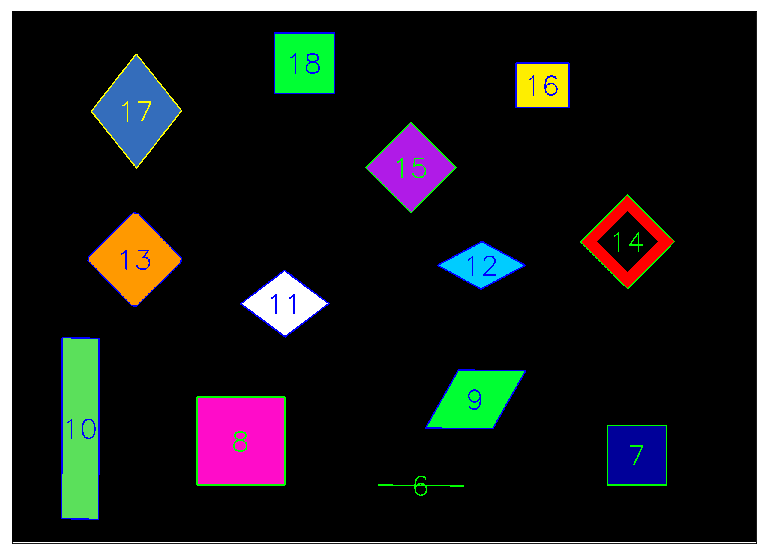

In [11]:
# OpenCv uses BRG format, convert it to RGB
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save image
cv2.imwrite('generated_{}.png'.format(imageName),image)

# Plot image
fig=plt.figure(figsize=(12, 12), dpi= 80)
plt.xticks([]), plt.yticks([])
plt.imshow(RGB_img)
plt.show()

## Save results in file

In [12]:
# Save results
f = open('generated_{}.txt'.format(imageName),"w")
for r in results:
    f.write(','.join(list(r))+'\n')
f.close()

## Obtain real data set from file

In [13]:
f =  open('{}.txt'.format(imageName))
trueresults = list()
trueshapes = list()
truecolors = list()
truetriangles = list()
truequads = list()
for line in f:
    tr = tuple(line.strip().split(','))
    trueresults.append(tr)
    trueshapes.append(tr[1])
    truecolors.append(tr[2])
    truetriangles.append(tr[3])
    truequads.append(tr[4])

## Plot general shape confusion matrix

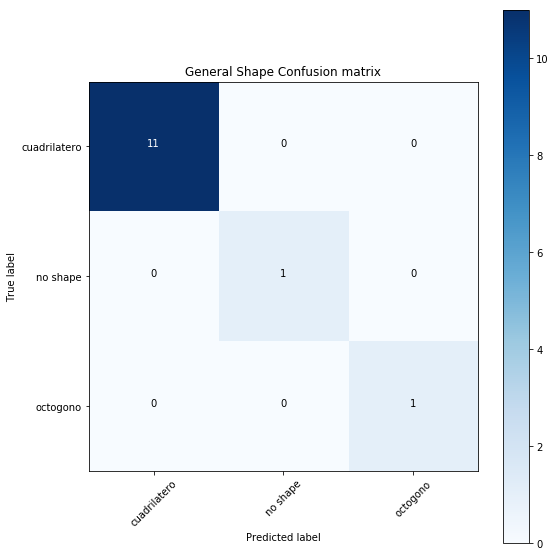

In [14]:
#Define true data and prediction for matrix
truedata = trueshapes
prediction = shapes

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='General Shape Confusion matrix')

## Plot color confusion matrix

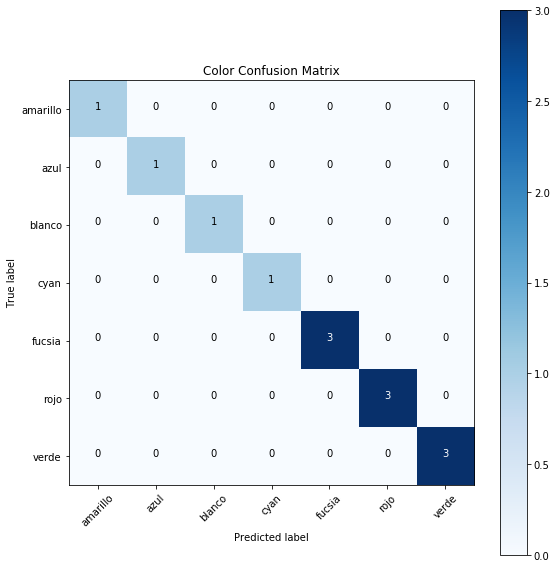

In [15]:
#Define true data and prediction for matrix
truedata = truecolors
prediction = colors

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Color Confusion Matrix')

## Plot triangular shape confusion matrix

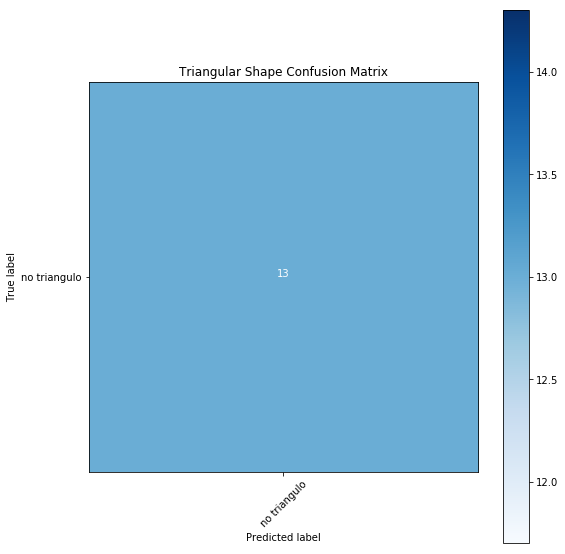

In [16]:
#Define true data and prediction for matrix
truedata = truetriangles
prediction = triangles

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Triangular Shape Confusion Matrix')

## Plot quadrilateral shape confusion matrix

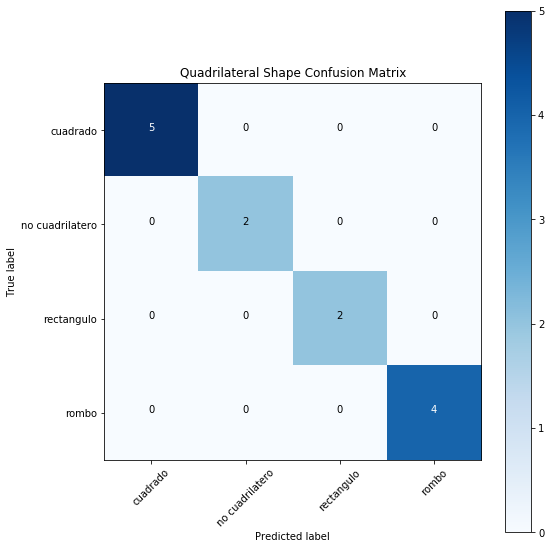

In [17]:
#Define true data and prediction for matrix
truedata = truequads
prediction = quads

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Quadrilateral Shape Confusion Matrix')